In [1]:
from plot_module import save_plot

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)

In [3]:
df.head()

,Volume
Production Date,
2015-01-01,67515553.0
2015-02-01,61664960.0
2015-03-01,66342950.0
2015-04-01,67719040.0
2015-05-01,66484591.0


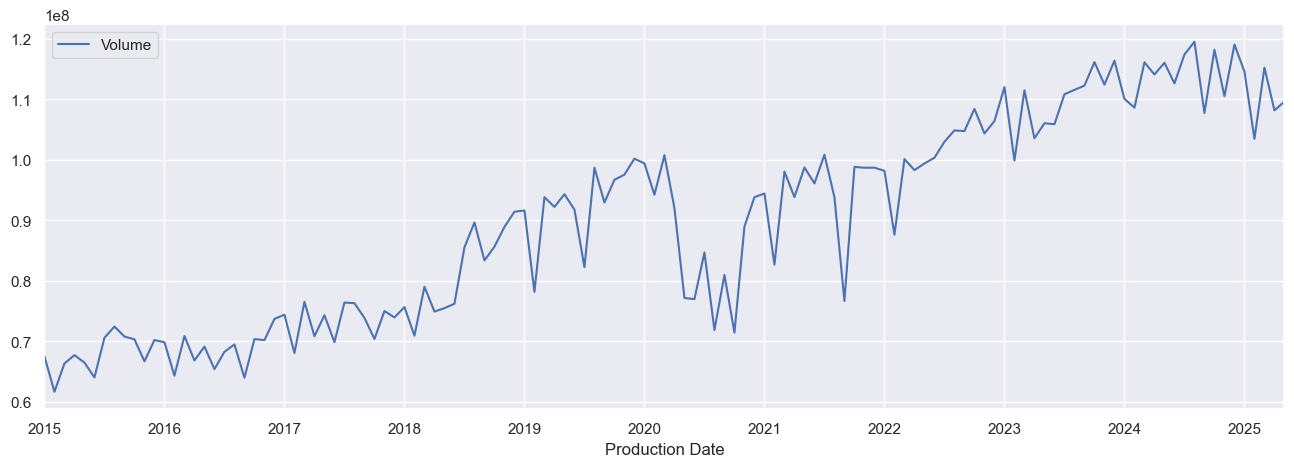

In [4]:
df.index.freq = 'MS'
df.plot(figsize=(16, 5));

## Checking Stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf(x): 
    res = adfuller(x)
    print('Test Statistic:', res[0]) 
    print('P-Value:', res[1]) 

    if res[1] < 0.05: 
        print('Stationary')
    else:
        print('Non-Stationary') 

adf(df.Volume)

Test Statistic: -1.344737549600928
P-Value: 0.6084645921750879
Non-Stationary


## Differencing

Test Statistic: -4.890839964217605
P-Value: 3.63347590898391e-05
Stationary


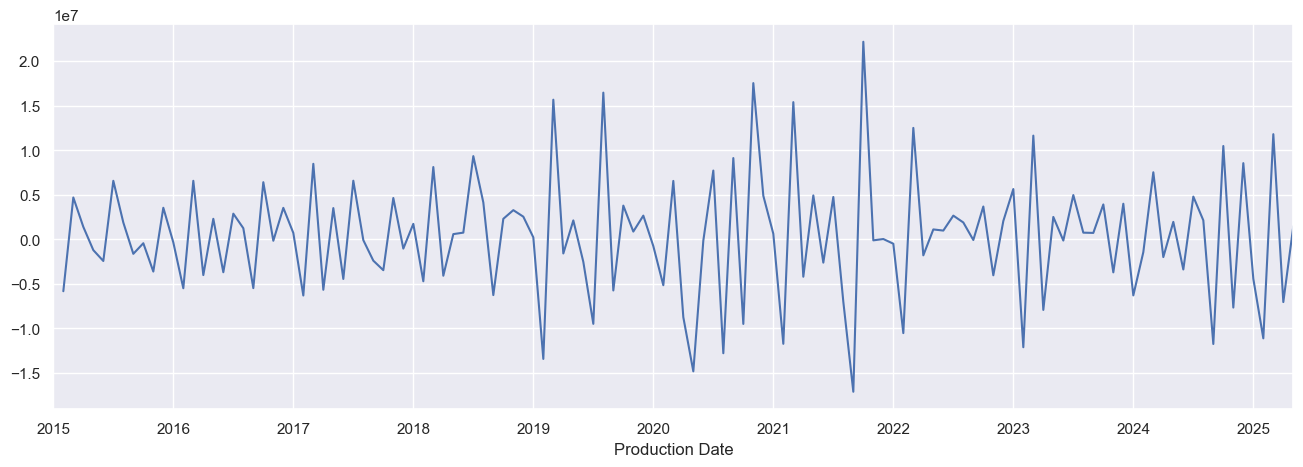

In [6]:
df['1stDiff'] = df['Volume'].diff() 
df['1stDiff'].plot(figsize=(16,5));
adf(df['1stDiff'].dropna())

## ACF

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

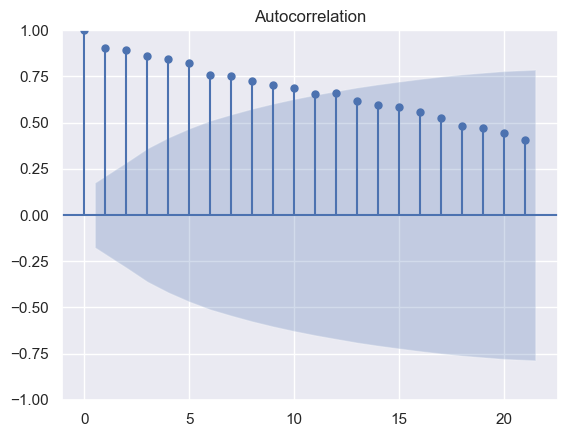

In [8]:
plot_acf(df['Volume']);

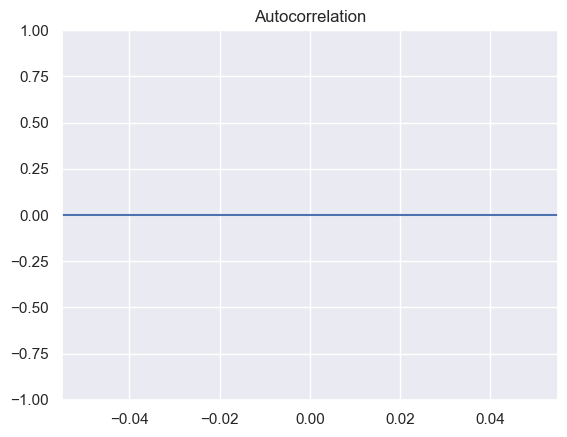

In [9]:
plot_acf(df['1stDiff'],);

## PACF

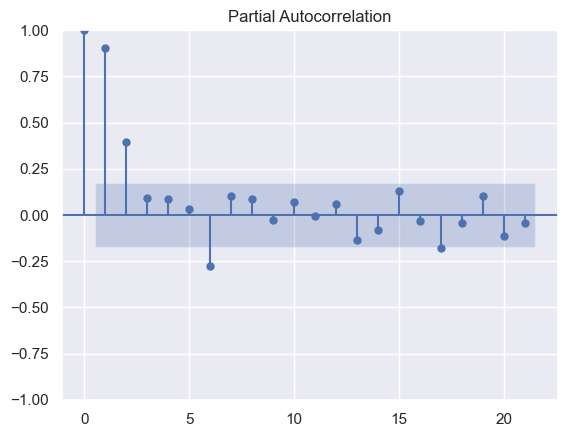

In [10]:
plot_pacf(df['Volume']);

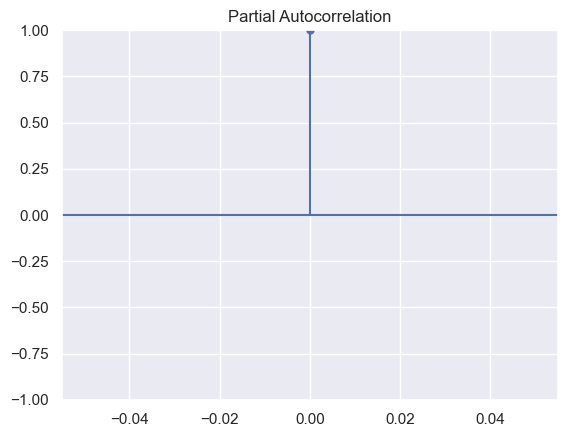

In [11]:
plot_pacf(df['1stDiff']);

_The ACF and PACF results indicate that the original series is non-stationary, while the first-differenced series exhibits no significant autocorrelation. This suggests that the data follows a random walk process, and an ARIMA(0,1,0) model is appropriate._

### Train/Test Split

In [12]:
Ntest = 12
train = df.iloc[:-Ntest] 
test = df.iloc[-Ntest:]

### ARIMA

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
arima = ARIMA(train['Volume'], order=(0,1,0)) 
result_arima_010 = arima.fit()

In [15]:
def plot_fit_and_forecast(result, d, model_name, col='Volume'): 
    fig, ax = plt.subplots(figsize=(12,6)) 
    ax.plot(df[col], label='data') 

    train_pred = result.predict(start=train.index[d], end=train.index[-1]) 
    ax.plot(train.index[d:], train_pred, color='green', label='fitted') 

    prediction_result = result.get_forecast(Ntest) 
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}'] 
    forecast = prediction_result.predicted_mean 
    ax.plot(test.index, forecast, label='forecast') 
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Production Volume')
    save_plot(fig, f'{model_name}')
    ax.legend() 

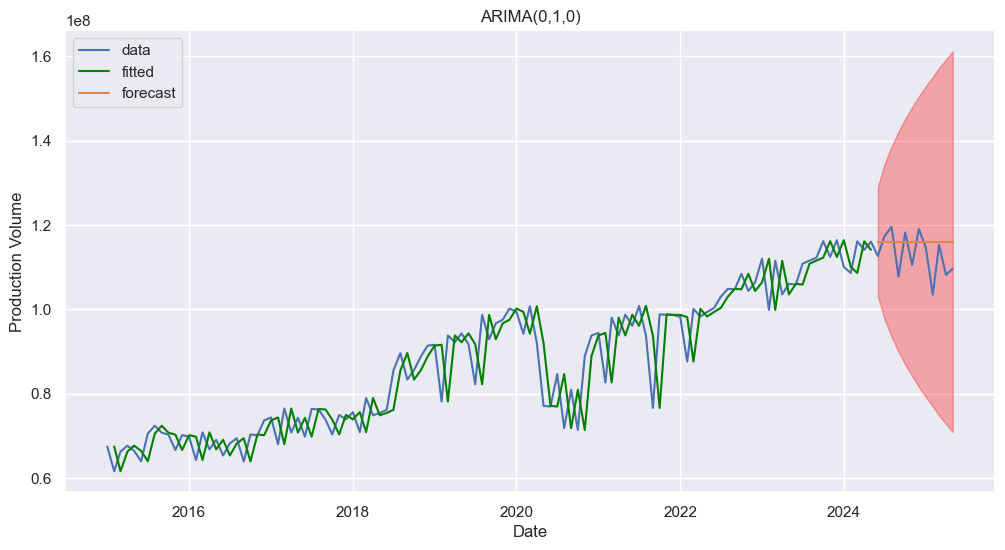

In [16]:
plot_fit_and_forecast(result_arima_010, 1, col='Volume', model_name='ARIMA(0,1,0)')

### Auto-ARIMA

In [17]:
import pmdarima as pm

In [18]:
model = pm.auto_arima(train['Volume'], start_p=0, start_q=0, max_p=3, max_q=3, d=1, seasonal=False,
                      suppress_warnings=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3841.218, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3822.665, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3822.947, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3839.696, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3824.184, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3824.291, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3826.376, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3822.294, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3824.118, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3824.049, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3822.392, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3826.096, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.671 seconds


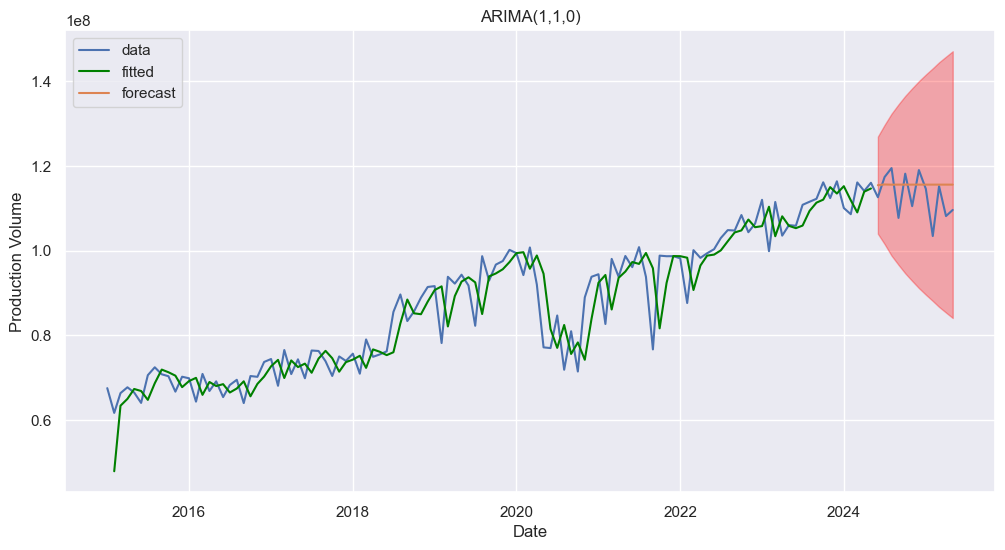

In [19]:
arima = ARIMA(train['Volume'], order=(1,1,0)) 
result_arima_110 = arima.fit()
plot_fit_and_forecast(result_arima_110, 1, col='Volume', model_name='ARIMA(1,1,0)')

In [20]:
model = pm.auto_arima(train['Volume'], start_p=0, start_q=0, max_p=5, max_q=5, d=1, seasonal=True,
                      suppress_warnings=True, trace=True, stepwise=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3837.575, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3841.218, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3822.633, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3823.387, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3839.696, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3822.665, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3821.749, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3822.707, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3823.151, Time=0.17 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3837.067, Time=0.13 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=3823.549, Time=0.25 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=3824.103, Time=0.31 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=3823.150, Time=0.24 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=3825.443, Time=0.84 sec
 ARIMA(1,1,0)(2,0,0

In [21]:
model = pm.auto_arima(train['Volume'], start_p=0, start_q=0, max_p=5, max_q=5, d=1, seasonal=True,
                      suppress_warnings=True, trace=True, stepwise=False, m=12)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3841.218, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3840.876, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3838.833, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3840.211, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3837.575, Time=0.14 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3835.907, Time=0.28 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3837.067, Time=0.16 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3836.121, Time=0.26 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=3837.884, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3822.947, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3823.387, Time=0.20 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3823.154, Time=0.45 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3823.500, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3825.320, Time=0.35 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3825.037, Time=0.49

### SARIMA

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

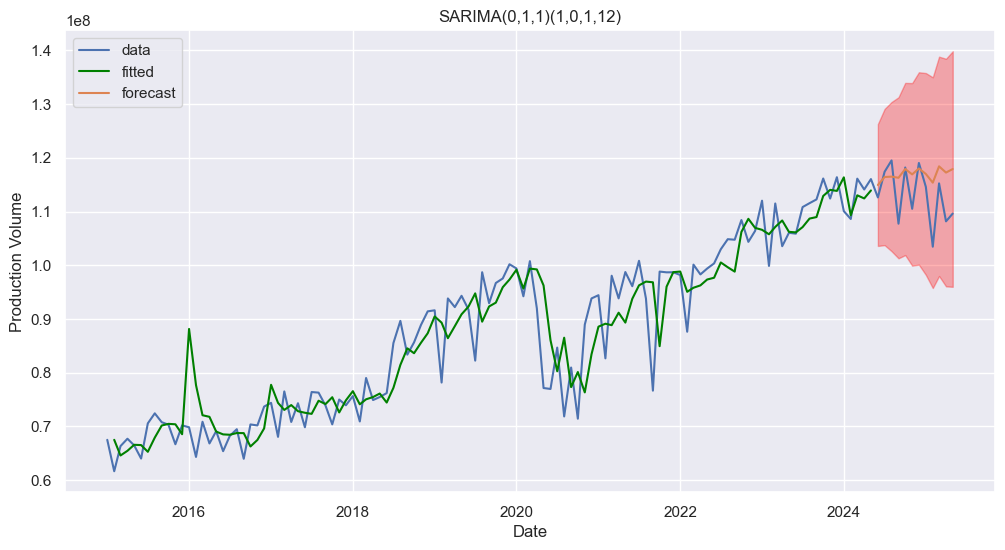

In [23]:
model = SARIMAX(train['Volume'], order=(0,1,1), seasonal_order=(1,0,1,12), enforce_stationarity=False,
                enforce_invertibility=False)

result_sarima_011_10112 = model.fit()
plot_fit_and_forecast(result_sarima_011_10112, 1, col='Volume', model_name='SARIMA(0,1,1)(1,0,1,12)')

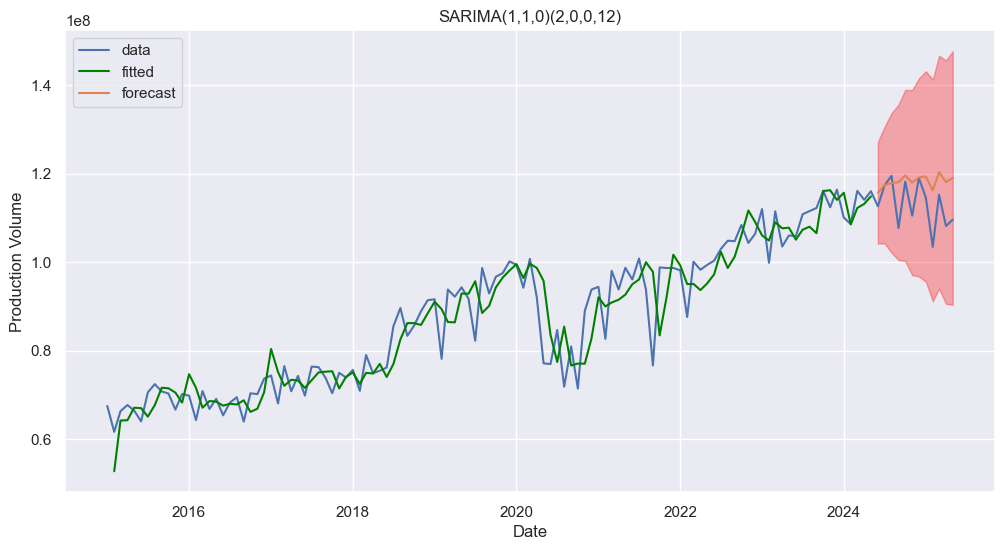

In [24]:
model = SARIMAX(train['Volume'], order=(1,1,0), seasonal_order=(2,0,0,12), enforce_stationarity=False,
                enforce_invertibility=False)

result_sarima_110_20012 = model.fit()
plot_fit_and_forecast(result_sarima_110_20012, 1, col='Volume', model_name='SARIMA(1,1,0)(2,0,0,12)')

### Residual Diagnostics

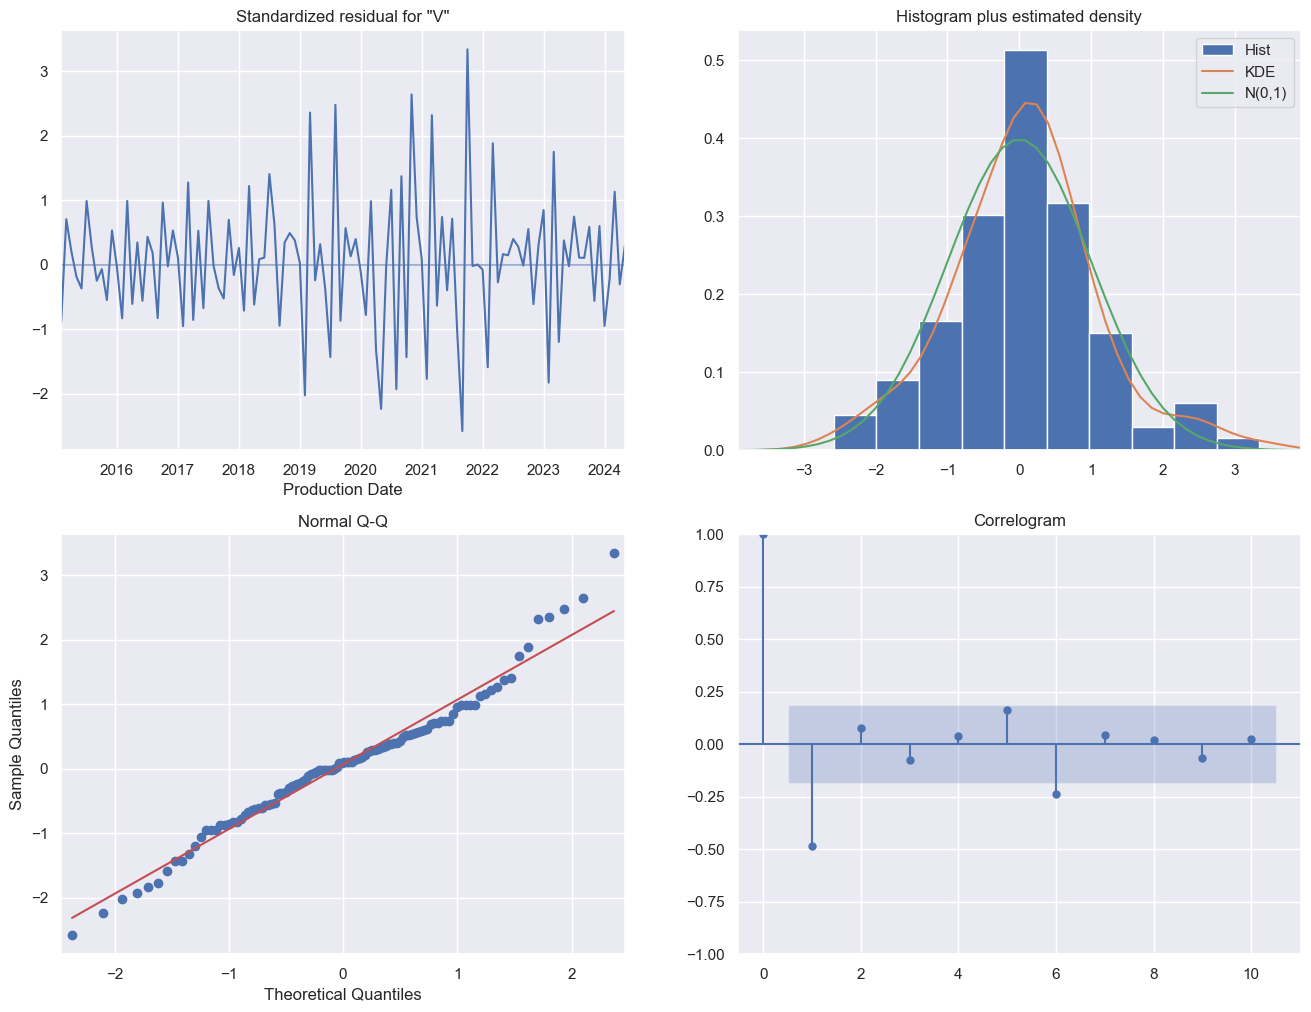

In [25]:
result_arima_010.plot_diagnostics(figsize=(16,12));

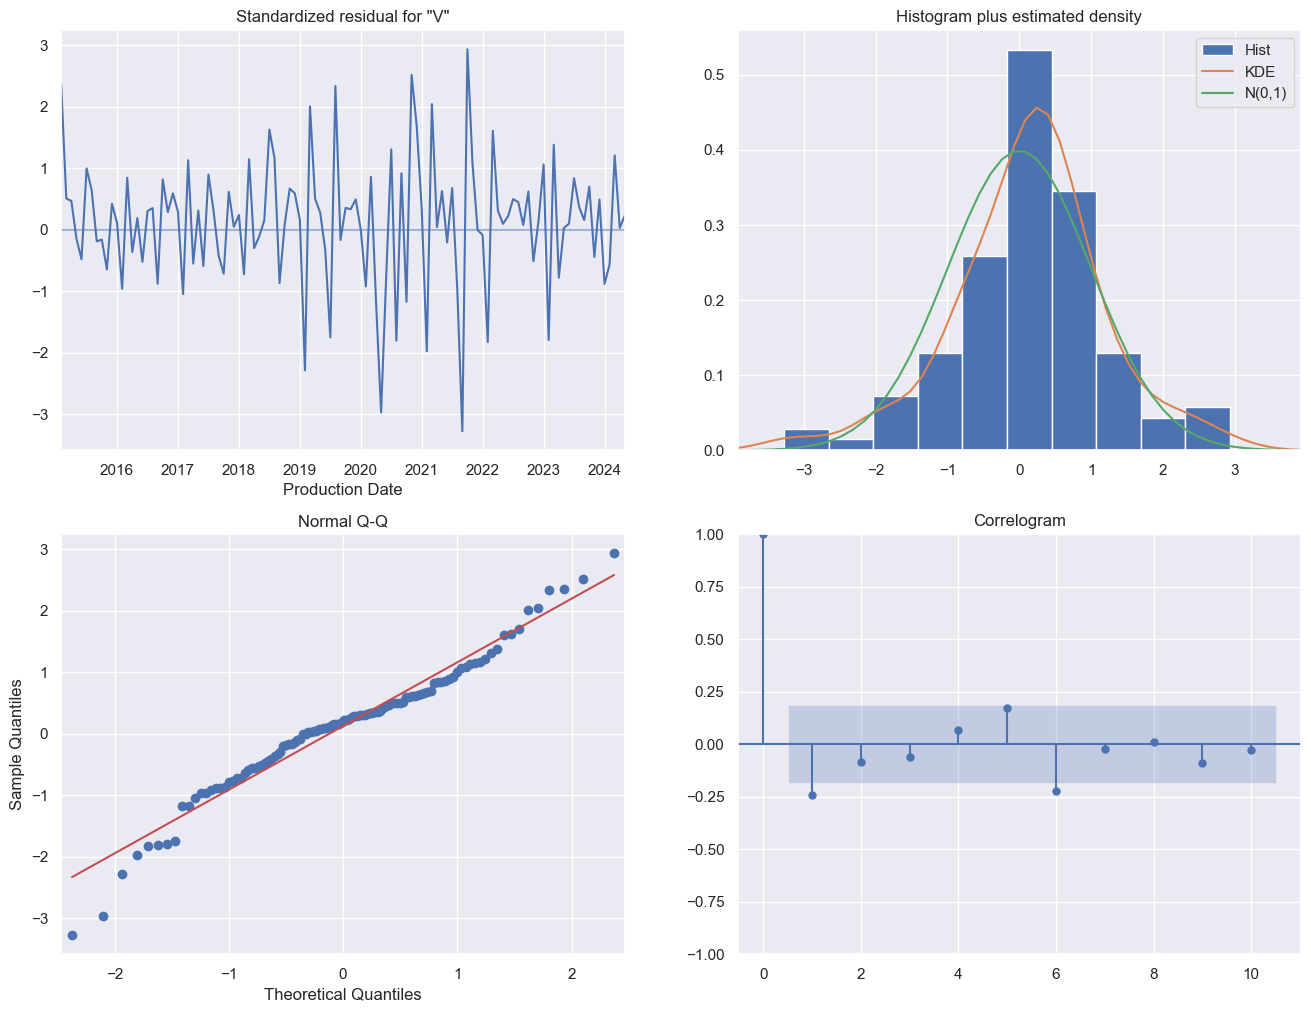

In [26]:
result_arima_110.plot_diagnostics(figsize=(16,12));

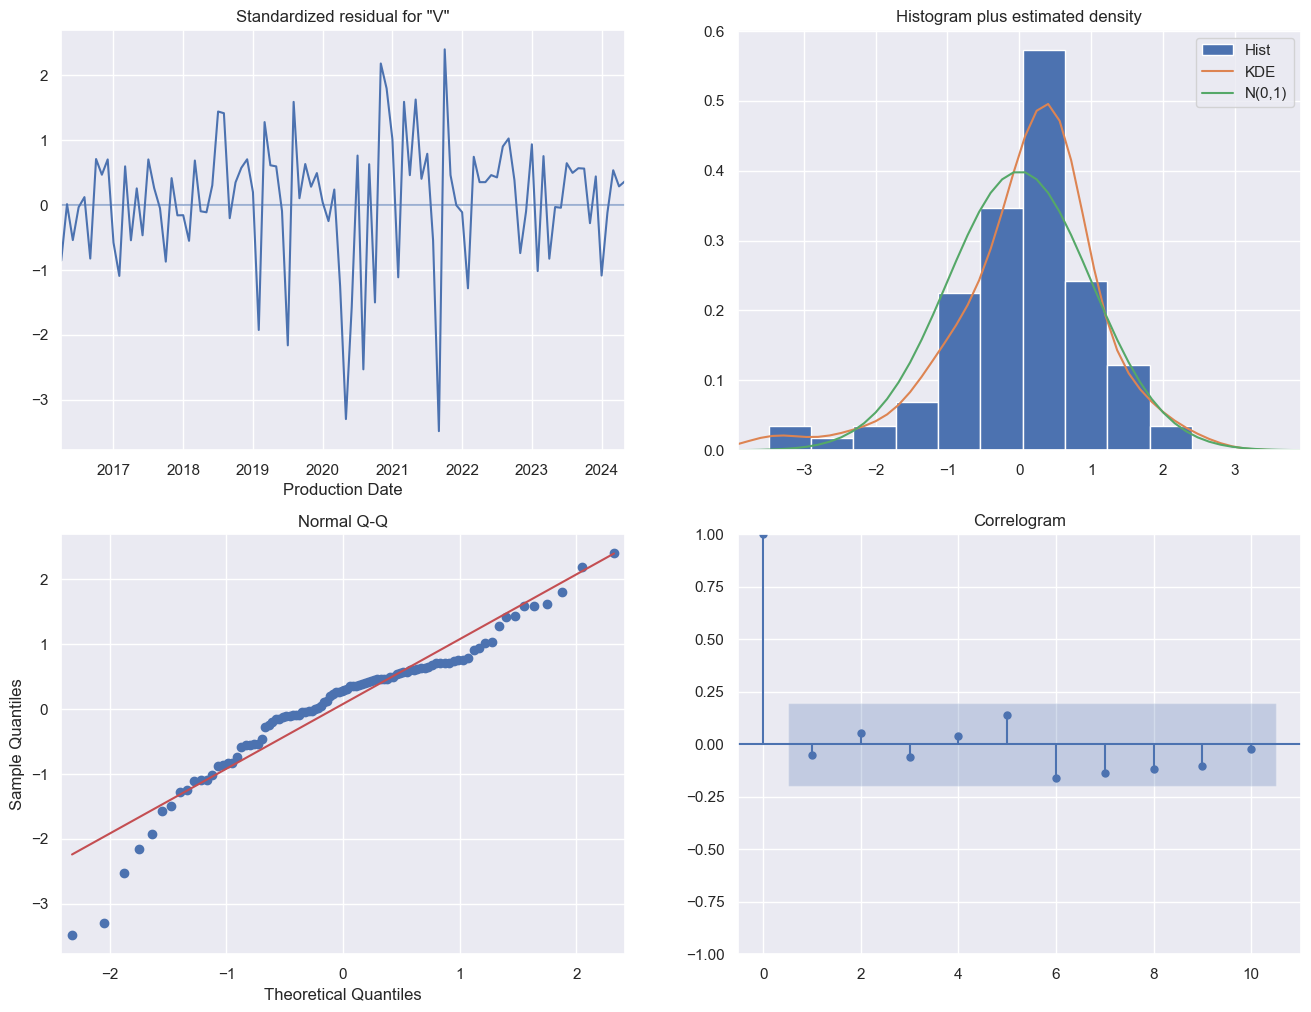

In [27]:
result_sarima_011_10112.plot_diagnostics(figsize=(16,12));

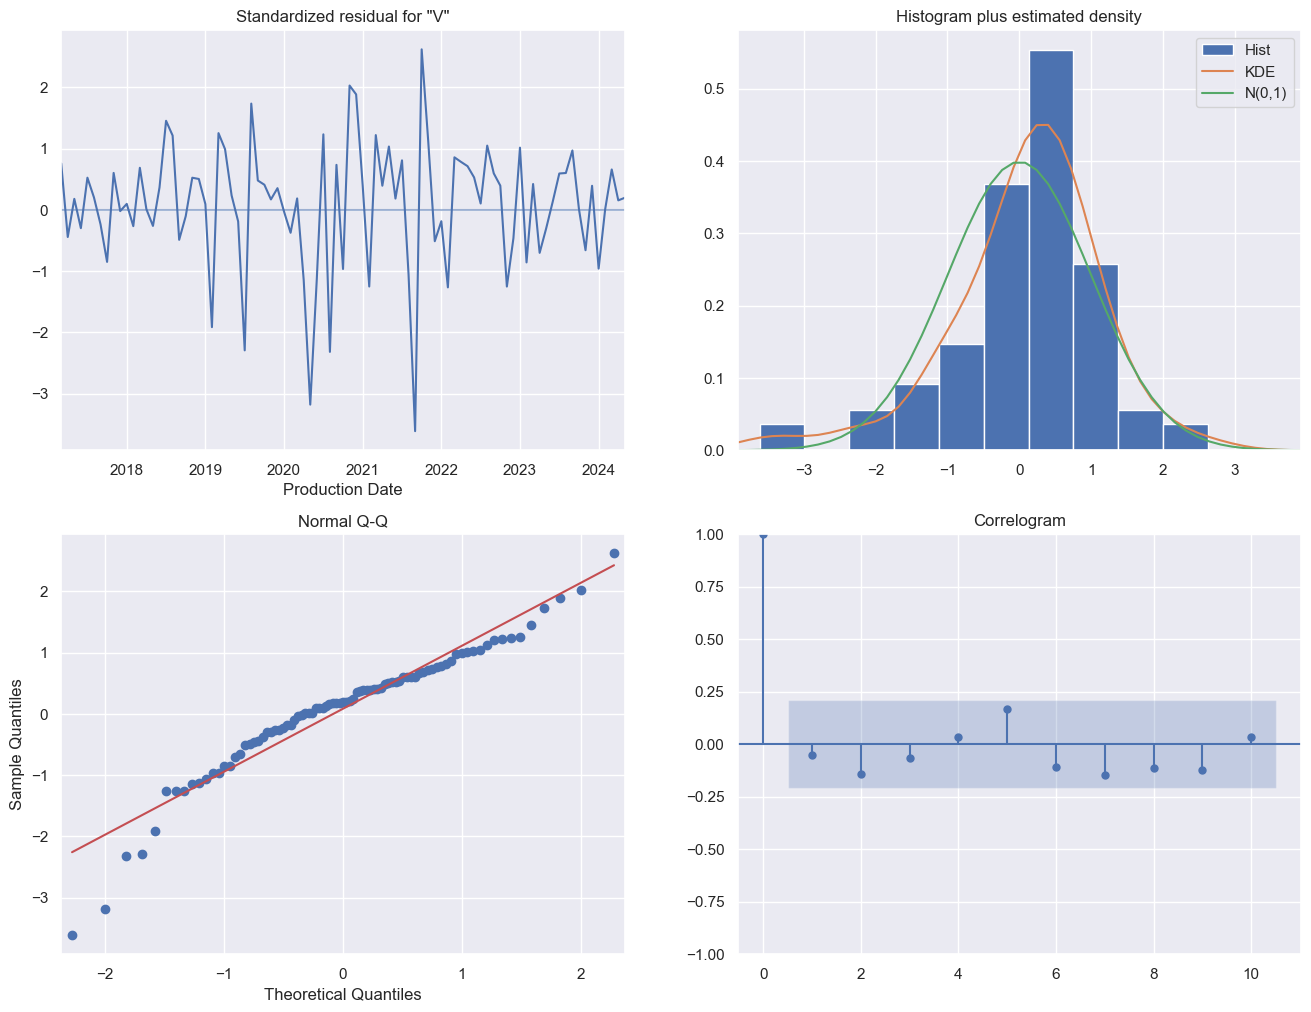

In [28]:
result_sarima_110_20012.plot_diagnostics(figsize=(16,12));

Residual diagnostics were performed to verify ARIMA assumptions. Residuals were centered around zero, uncorrelated, and approximately normally distributed, indicating the model adequately captured trends and seasonality.

### Metrics

### MAE

In [29]:
def mae (result): 
    forecast = result.forecast(Ntest)
    t = test['Volume'] 
    y = forecast 
    return mean_absolute_error(t, y)

In [30]:
print('MAE ARIMA (0,1,0):',mae(result_arima_010)) 
print('MAE ARIMA (1,1,0):',mae(result_arima_110))
print('MAE SARIMA (0,1,1)(1,0,1,12):',mae(result_sarima_011_10112)) 
print('MAE SARIMA (1,1,0)(2,0,0,12):', mae(result_sarima_110_20012))

MAE ARIMA (0,1,0): 4696853.166666667
MAE ARIMA (1,1,0): 4538933.012788338
MAE SARIMA (0,1,1)(1,0,1,12): 4785234.257847383
MAE SARIMA (1,1,0)(2,0,0,12): 5506255.857185542


#### RMSE

In [31]:
def rmse (result): 
    forecast = result.forecast(Ntest)
    t = test['Volume'] 
    y = forecast 
    return np.sqrt(np.mean((t-y)**2)) 

In [32]:
print('RMSE ARIMA (0,1,0):',rmse(result_arima_010)) 
print('RMSE ARIMA (1,1,0):',rmse(result_arima_110))
print('RMSE SARIMA (0,1,1)(1,0,1,12):',rmse(result_sarima_011_10112)) 
print('RMSE SARIMA (1,1,0)(2,0,0,12):', rmse(result_sarima_110_20012))

RMSE ARIMA (0,1,0): 5795362.870161123
RMSE ARIMA (1,1,0): 5574067.283580957
RMSE SARIMA (0,1,1)(1,0,1,12): 6053430.481587058
RMSE SARIMA (1,1,0)(2,0,0,12): 6928738.4439750165


#### R^2

In [33]:
from sklearn.metrics import r2_score 

def r2(result):
    forecast = result.forecast(Ntest) 
    t = test['Volume'] 
    y = forecast
    return r2_score(t, y)    

In [34]:
print('R2 ARIMA (0,1,0):',r2(result_arima_010)) 
print('R2 ARIMA (1,1,0):',r2(result_arima_110))
print('R2 SARIMA (0,1,1)(1,0,1,12):',r2(result_sarima_011_10112)) 
print('R2 SARIMA (1,1,0)(2,0,0,12):', r2(result_sarima_110_20012))

R2 ARIMA (0,1,0): -0.3762677643410681
R2 ARIMA (1,1,0): -0.273169080685036
R2 SARIMA (0,1,1)(1,0,1,12): -0.5015672525555024
R2 SARIMA (1,1,0)(2,0,0,12): -0.9672067423910333


### MAPE

In [35]:
def mape (result): 
    forecast = result.forecast(Ntest)
    t = test['Volume'] 
    y = forecast 
    return mean_absolute_percentage_error(t, y)

In [36]:
print('MAPE ARIMA (0,1,0):',mape(result_arima_010)) 
print('MAPE ARIMA (1,1,0):',mape(result_arima_110))
print('MAPE SARIMA (0,1,1)(1,0,1,12):',mape(result_sarima_011_10112)) 
print('MAPE SARIMA (1,1,0)(2,0,0,12):', mape(result_sarima_110_20012))

MAPE ARIMA (0,1,0): 0.042832951275335894
MAPE ARIMA (1,1,0): 0.041308616133766234
MAPE SARIMA (0,1,1)(1,0,1,12): 0.04379313964819922
MAPE SARIMA (1,1,0)(2,0,0,12): 0.05039595779907543


### Conclusion

1. ARIMA(1,1,0) is the best-performing model.
2. SARIMA models did not improve performance, indicating weak or irregular seasonality in the data.